# Aramco Inn. Intern Home Task

The task is to come up with the methodology to select features and evaluate time lags which should be used to build a robust predictive model for forecasting the flow rates of wells P1 and P2 for a 3-step horizon using provided reservoir simulation data.

This solution is focused on modeling oil flow rates of P1 & P2.

-----
Nikita Zinovich

see more at https://github.com/zeinovich/aramco-solution/tree/master/notebooks

### Table of Contents
* [Data](#data)
    * [Plotting](#plotting)
* [Baseline](#baseline)
    * [Dummy Regressor](#dummy-regressor)
    * [Train&Test Functions](#train-test-functions)
* [Feature Engineering & Selection](#feature-engineering)
    * [Initial Feature Selection](#initial-feature-selection)
    * [Feature Engineering](#feature-engineering)
    * [Feature Selection from Random Forest](#feature-selection-from-random-forest)
        * [Lags Interpretation](#lags-interpretation)
* [Model Selection & Hyperparameter Tuning](#model-selection-hyperparameter-tuning)
    * [Hyperparameter Tuning](#hyperparameter-tuning)
    * [Model Sanity Check](#model-sanity-check)
* [Model Evaluation & Error Analysis](#model-evaluation-error-analysis)
    * [Error Distribution](#error-distribution)
    * [Error Quantile Comparison](#error-quantile-comparison)
    * [Statistical Significance](#statistical-significance)
    * [Error Analysis by coef](#error-analysis-by-coef)
* [Suggestions for improvement](#suggestions-for-improvement)
* [Summary](#summary)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import itertools

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import f_regression, VarianceThreshold
from sklearn.ensemble import RandomForestRegressor

plt.style.use('seaborn-v0_8')

# 1. Data <span class="anchor" id="data"></span>

In [4]:
data = pd.read_csv('../data/data.csv')
data.head()

,cat,group,date,oil,water,liquid,bhp,status,start_lag,coef,is_base
0,P1,P,0,-0.001621,0.000000,-0.001621,2.000000e+07,1.0,19.0,0.42,False
1,P2,P,0,-0.001903,0.000000,-0.001903,2.000000e+07,1.0,19.0,0.42,False
2,I1,I,0,NaN,0.002533,0.002533,4.018987e+07,1.0,19.0,0.42,False
3,I2,I,0,NaN,0.001267,0.001267,3.665494e+07,1.0,19.0,0.42,False
4,I3,I,0,NaN,NaN,NaN,NaN,0.0,19.0,0.42,False


In [5]:
meta = pd.read_csv('../data/meta.csv')
meta.head()

,cat,x,y
0,P1,190,190
1,P2,190,890
2,I1,890,190
3,I2,590,770
4,I3,670,510


In [6]:
data = data.merge(meta, on='cat', how='left', suffixes=('', ''))
data.head()

,cat,group,date,oil,water,liquid,bhp,status,start_lag,coef,is_base,x,y
0,P1,P,0,-0.001621,0.000000,-0.001621,2.000000e+07,1.0,19.0,0.42,False,190,190
1,P2,P,0,-0.001903,0.000000,-0.001903,2.000000e+07,1.0,19.0,0.42,False,190,890
2,I1,I,0,NaN,0.002533,0.002533,4.018987e+07,1.0,19.0,0.42,False,890,190
3,I2,I,0,NaN,0.001267,0.001267,3.665494e+07,1.0,19.0,0.42,False,590,770
4,I3,I,0,NaN,NaN,NaN,NaN,0.0,19.0,0.42,False,670,510


## 1.1 Plotting <span class="anchor" id="plotting"></span>

In [7]:
# select production well data only
p_data = data[data.group == 'P']

# print unique values for each column
print(p_data.start_lag.unique())
print(p_data.coef.unique())
print(p_data.cat.unique())

[19. 21. 17. 10. 11. 16. 20. 18.  5.  2.  3.  4. 22. 13. 14. 15. 12. 24.
 23.  8.  1.  6.  7.  9. nan]
[0.42 0.17 0.33 0.67 0.58 0.5  0.25 0.08  nan]
['P1' 'P2']


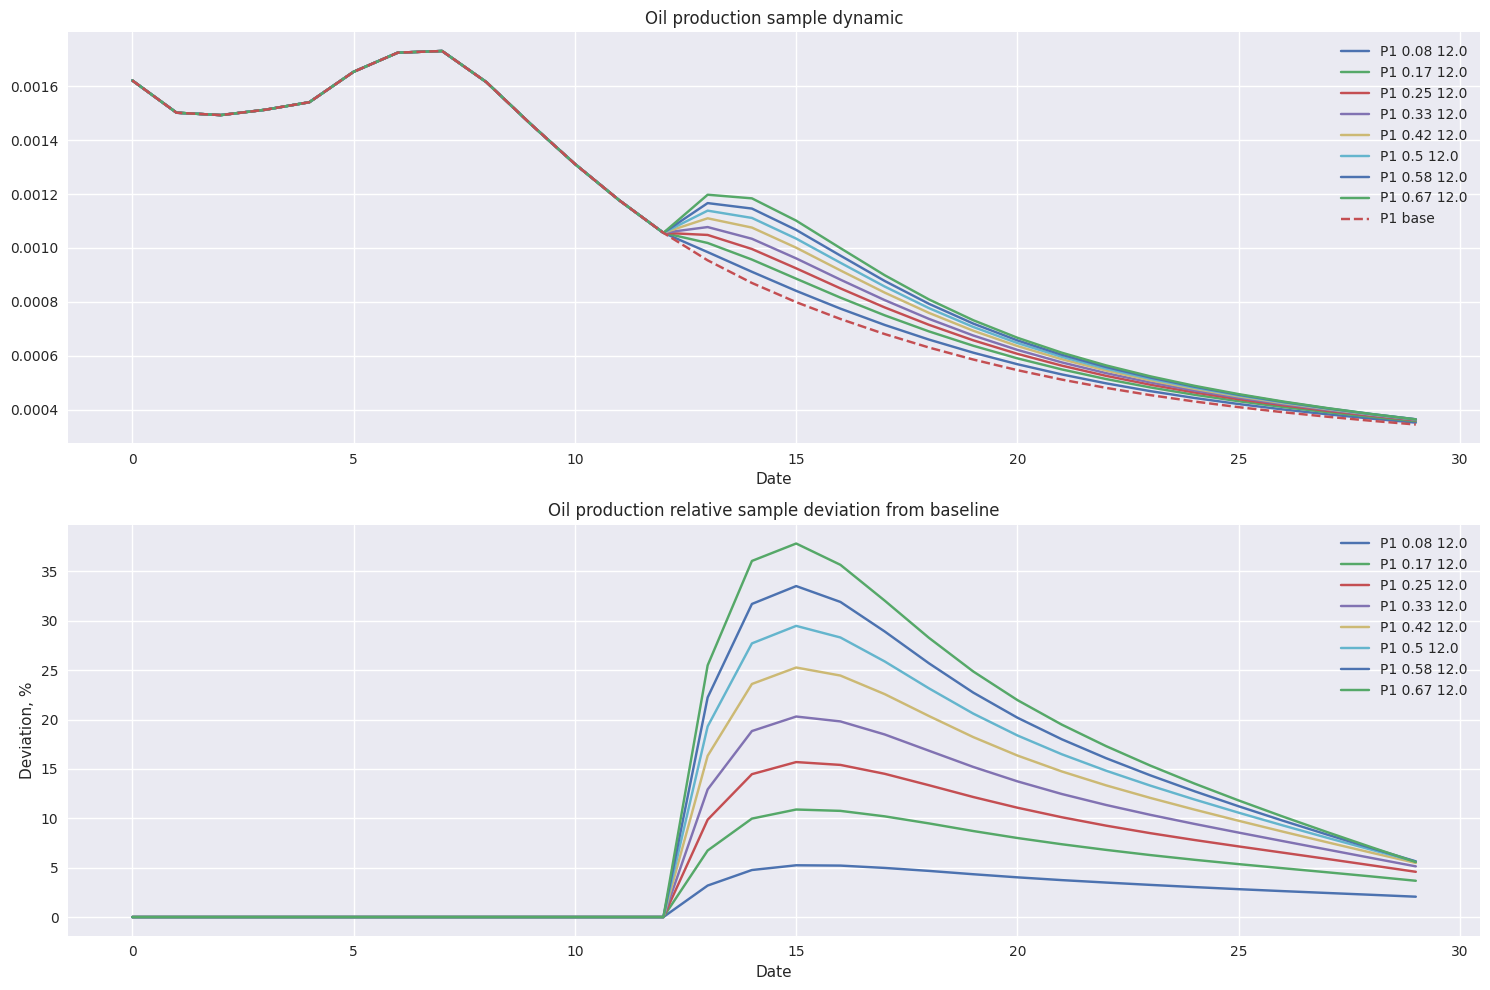

In [10]:
fig, ax = plt.subplots(figsize=(15, 10), 
                       nrows=2, ncols=1,
                       sharex=False,
                       layout='tight')

start_lag_sample = np.random.choice(p_data.start_lag.dropna().unique(), 1)
coef_sample = p_data.coef.dropna().unique()
coef_sample.sort()
cat_sample = np.random.choice(['P1', 'P2'], 1)

for start_lag, coef, well in itertools.product(start_lag_sample, coef_sample, cat_sample):
     data_sample = p_data[(p_data.cat == well) &
                          (p_data.coef == coef) &
                          (p_data.start_lag == start_lag)]
     
     base_sample = p_data[(p_data.cat == well) &
                          (p_data.is_base)]
     
     
     ax[0].plot(data_sample['date'], np.abs(data_sample['oil']), 
              label=f'{well} {coef} {start_lag}')
     
     ax[1].plot(data_sample['date'], ((np.array(base_sample.oil)  - np.array(data_sample.oil)) 
                                      / np.array(- base_sample.oil)) * 100,
                    label=f'{well} {coef} {start_lag}')
     

for well in cat_sample:
     base_sample = p_data[(p_data.cat == well) &
                          (p_data.is_base)]
     
     ax[0].plot(base_sample['date'], np.abs(base_sample['oil']), 
              label=f'{well} base', linestyle='--') 
                          

ax[0].legend()
ax[0].set_title('Oil production sample dynamic')
ax[0].set_xlabel('Date')

ax[1].legend()
ax[1].set_title('Oil production relative sample deviation from baseline')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Deviation, %')

plt.show()

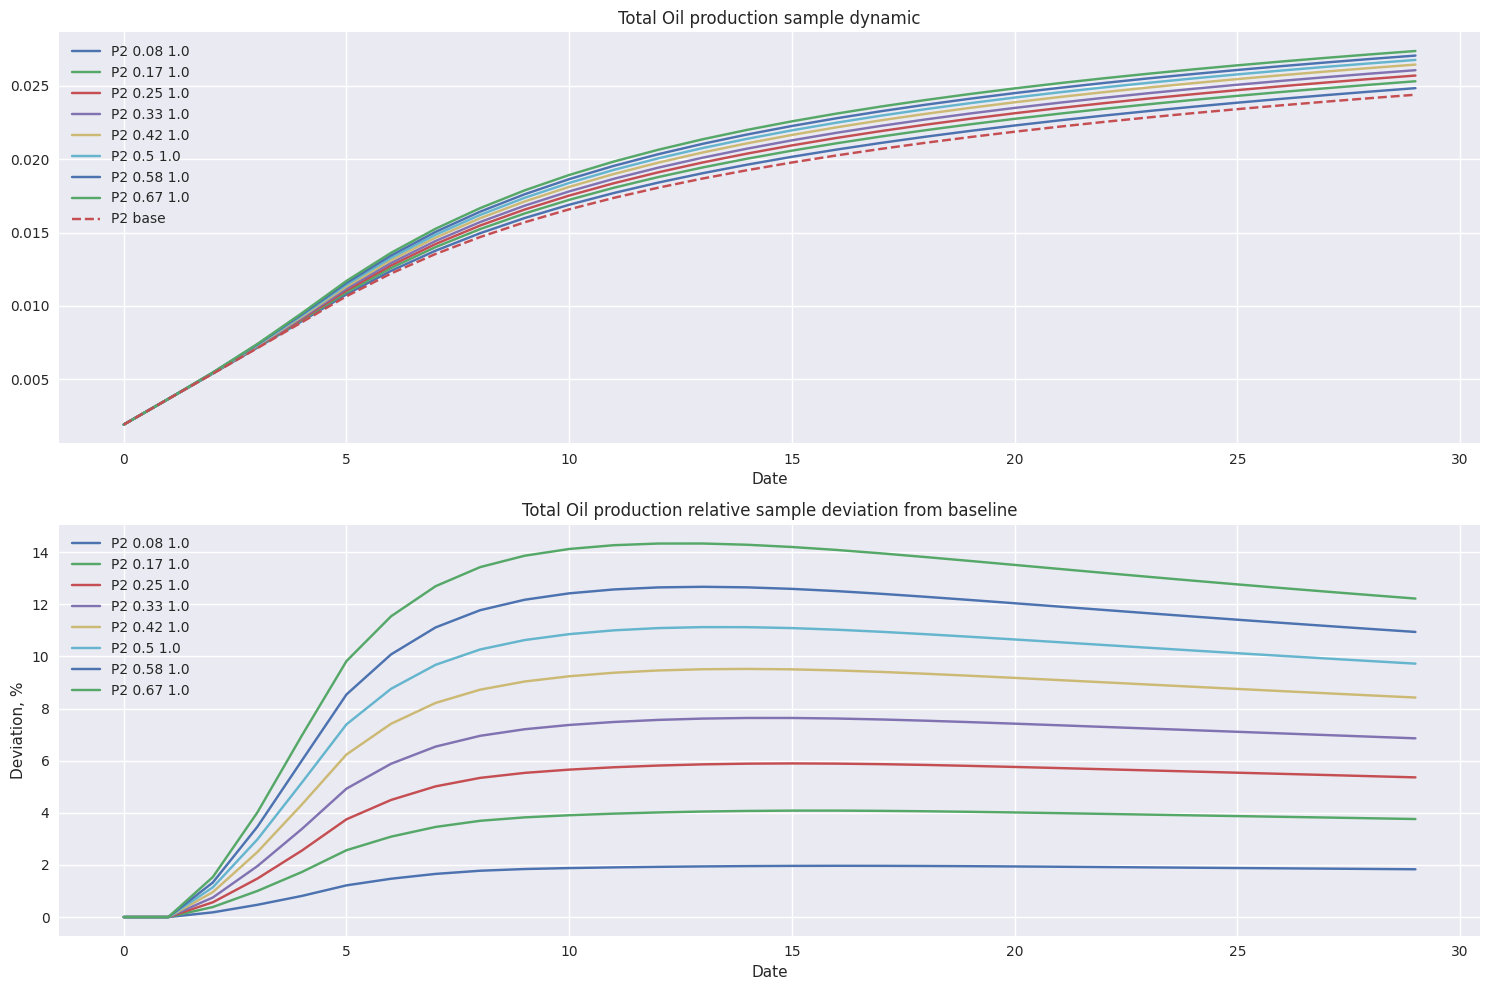

In [12]:
fig, ax = plt.subplots(figsize=(15, 10), 
                       nrows=2, ncols=1,
                       sharex=False,
                       layout='tight')

start_lag_sample = np.random.choice(p_data.start_lag.dropna().unique(), 1)
coef_sample = p_data.coef.dropna().unique()
coef_sample.sort()
cat_sample = np.random.choice(['P1', 'P2'], 1)

for start_lag, coef, well in itertools.product(start_lag_sample, coef_sample, cat_sample):
     data_sample = p_data[(p_data.cat == well) &
                          (p_data.coef == coef) &
                          (p_data.start_lag == start_lag)]
     
     base_sample = p_data[(p_data.cat == well) &
                          (p_data.is_base)]
     
     
     ax[0].plot(data_sample['date'], np.abs(np.cumsum(data_sample['oil'])), 
                label=f'{well} {coef} {start_lag}')
     
     ax[1].plot(data_sample['date'], ((np.cumsum(np.array(base_sample.oil))
                                       - np.cumsum(np.array(data_sample.oil))) 
                                       / np.cumsum(np.array(- base_sample.oil))) * 100,
                    label=f'{well} {coef} {start_lag}')
     

for well in cat_sample:
     base_sample = p_data[(p_data.cat == well) &
                          (p_data.is_base)]
     
     ax[0].plot(base_sample['date'], np.abs(np.cumsum(base_sample['oil'])), 
              label=f'{well} base', linestyle='--') 
                          

ax[0].legend()
ax[0].set_title('Total Oil production sample dynamic')
ax[0].set_xlabel('Date')

ax[1].legend()
ax[1].set_title('Total Oil production relative sample deviation from baseline')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Deviation, %')

plt.show()

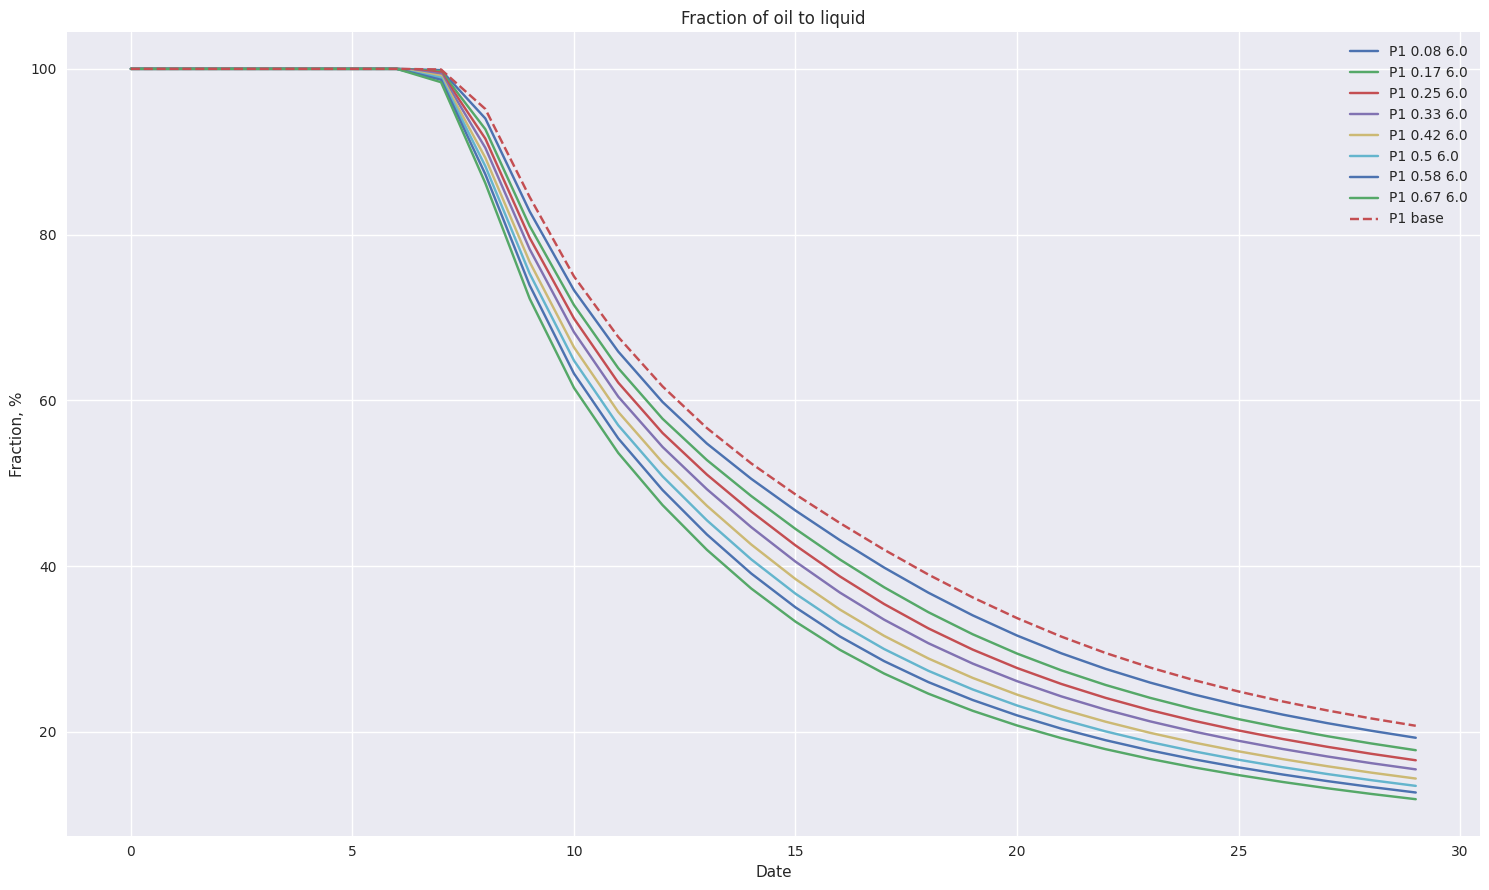

In [18]:
fig, ax = plt.subplots(figsize=(15, 9), 
                       nrows=1, ncols=1,
                       sharex=False,
                       layout='tight')

start_lag_sample = np.random.choice(p_data.start_lag.dropna().unique(), 1)
coef_sample = p_data.coef.dropna().unique()
coef_sample.sort()
cat_sample = np.random.choice(['P1', 'P2'], 1)

for start_lag, coef, well in itertools.product(start_lag_sample, coef_sample, cat_sample):
     data_sample = p_data[(p_data.cat == well) &
                          (p_data.coef == coef) &
                          (p_data.start_lag == start_lag)]
     
     base_sample = p_data[(p_data.cat == well) &
                          (p_data.is_base)]
     
     
     ax.plot(data_sample['date'], data_sample['oil'] / data_sample['liquid'] * 100, 
              label=f'{well} {coef} {start_lag}')
     
for well in cat_sample:
     base_sample = p_data[(p_data.cat == well) &
                          (p_data.is_base)]
     
     ax.plot(base_sample['date'], base_sample['oil'] / base_sample['liquid'] * 100, 
              label=f'{well} base', linestyle='--') 
     
ax.legend()
ax.set_title('Fraction of oil to liquid')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction, %')
plt.show()

# 2. Baseline <span class="anchor" id="baseline"></span>

In [19]:
# select not baseline data
not_baseline = p_data[~p_data.is_base].drop('is_base', axis=1).sort_values('date')
not_baseline

,cat,group,date,oil,water,liquid,bhp,status,start_lag,coef,x,y
0,P1,P,0,-0.001621,0.000000,-0.001621,20000000.0,1.0,19.0,0.42,190,190
15751,P2,P,0,-0.001903,0.000000,-0.001903,20000000.0,1.0,2.0,0.58,190,890
15750,P1,P,0,-0.001621,0.000000,-0.001621,20000000.0,1.0,2.0,0.58,190,190
15601,P2,P,0,-0.001903,0.000000,-0.001903,20000000.0,1.0,5.0,0.58,190,890
15600,P1,P,0,-0.001621,0.000000,-0.001621,20000000.0,1.0,5.0,0.58,190,190
...,...,...,...,...,...,...,...,...,...,...,...,...
18746,P2,P,29,-0.000253,-0.002979,-0.003232,20000000.0,1.0,11.0,0.50,190,890
18895,P1,P,29,-0.000386,-0.002089,-0.002475,20000000.0,1.0,16.0,0.50,190,190
18896,P2,P,29,-0.000267,-0.002980,-0.003248,20000000.0,1.0,16.0,0.50,190,890
18295,P1,P,29,-0.000420,-0.002052,-0.002472,20000000.0,1.0,21.0,0.50,190,190


In [21]:
# select baseline data
baseline = p_data[p_data.is_base].drop('is_base', axis=1).sort_values('date')
baseline.head()

,cat,group,date,oil,water,liquid,bhp,status,start_lag,coef,x,y
28800,P1,P,0,-0.001621,0.0,-0.001621,20000000.0,1.0,NaN,NaN,190,190
28801,P2,P,0,-0.001903,0.0,-0.001903,20000000.0,1.0,NaN,NaN,190,890
28804,P1,P,1,-0.001502,0.0,-0.001502,20000000.0,1.0,NaN,NaN,190,190
28805,P2,P,1,-0.001747,0.0,-0.001747,20000000.0,1.0,NaN,NaN,190,890
28808,P1,P,2,-0.001493,0.0,-0.001493,20000000.0,1.0,NaN,NaN,190,190


## 2.1 Dummy Regressor <span class="anchor" id="dummy-regressor"></span>

As baseline I will use the just baseline values for each date and coef

In [24]:
class DummyRegressor():
    def __init__(self, baseline=None):
        self.baseline = baseline
    
    def fit(self, X, y):
        pass

    def predict(self, X: pd.DataFrame):
        preds = pd.merge(X, self.baseline, on=['cat', 'date'], how='left', suffixes=('', '_base'))
        preds = preds['oil_base'].values
        return np.array(preds)

## 2.2 Training & Testing Functions <span class="anchor" id="train-test-functions"></span>

For training and testing I used TimeSeriesCV. For each date from day 2 (date starts from 0) to day 27 I trained model on all previous dates and tested on 3 following dates. 
- On day 6 model is trained on [day0, day1, ... , day5] and tested on [day6, day7, day8]
- On day 27 model is trained on [day0, day1, ... , day26] and tested on [day27, day28, day29]

The errors account only for dates after I3 was introduced. 

As performance metric I used MAPE.

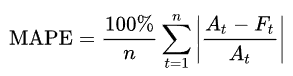

In [26]:
def train_fn(data, model, horizon):    
    train = data[data.date < horizon]
    test = data[(data.date >= horizon) & (data.date < horizon + 3)]

    model.fit(X=train.drop(['oil', 'water', 'liquid'], axis=1), y=train.oil)
    afterI3 = test[test.date >= test.start_lag]
    y_pred = model.predict(afterI3)   
    return mean_absolute_percentage_error(afterI3.oil, y_pred) * 100

def train_model(data, model, stride=1):    
    mapes = [train_fn(data, model, i) for i in range(2, 28, stride)]
    
    plt.bar(range(2, 28, stride), mapes)
    plt.title(f'MAPE for {model.__class__.__name__}, Mean = {np.mean(mapes):.2f}%')
    plt.xlabel('Horizon, day')
    plt.ylabel('MAPE, %')
    plt.show()
    return model

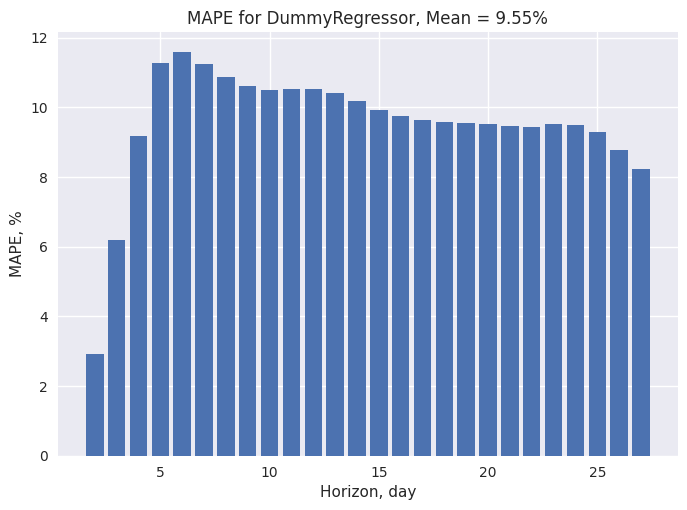

In [27]:
dr = DummyRegressor(baseline=baseline)

mapes = train_model(not_baseline, dr, stride=1)

In [28]:
# funcs to get error distribution

def train_fn_aux(data, model, horizon, cols):    
    train = data[data.date < horizon]
    test = data[(data.date >= horizon) & (data.date < horizon + 3)]

    model.fit(X=train.drop(['oil', 'water', 'liquid'], axis=1), y=train.oil)
    
    afterI3 = test[test.date >= test.start_lag]
    y_pred = model.predict(afterI3)
    return np.abs((afterI3.oil - y_pred) / afterI3.oil * 100)

def train_model_aux(data, model, cols, stride=1):    
    mapes = [train_fn_aux(data, model, i, cols) for i in range(1, 27, stride)]
    return np.hstack(mapes)

def plot_mape(mapes):
    plt.figure(figsize=(10, 5))
    plt.hist(mapes, bins=100)
    q95 = np.quantile(mapes, 0.95)
    plt.title(f'Error disstribution\n{q95 = :.2f}%')
    plt.axvline(q95, color='red', linestyle='--', label='95% quantile')
    plt.xlabel('MAPE')
    plt.ylabel('Count')
    plt.legend()
    plt.show()   

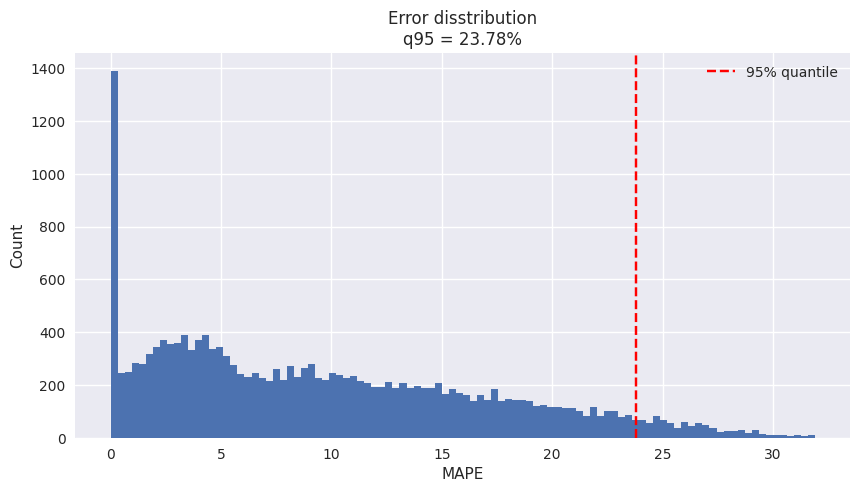

In [29]:
dr = DummyRegressor(baseline=baseline)

mapes = train_model_aux(not_baseline, dr, stride=1, cols=None)
plot_mape(mapes)

# 3. Feature Engineering & Selection <span class="anchor" id="feature-engineering"></span>

In [47]:
# select production and injection data
data = data.fillna(0)

p_data = data[data.group == 'P']
i_data = data[data.group == 'I']

In [48]:
# join production and injection data
for inj in i_data.cat.unique():
    inj_data = i_data[i_data.cat == inj].drop(columns=['cat', 'group', 
                                                       'oil', 'liquid', 
                                                       'is_base', 'x', 'y'])

    p_data = p_data.merge(inj_data, 
                          on=['start_lag', 'coef', 'date'], 
                          suffixes=('', f'_{inj}'),
                          how='left')

In [49]:
data_init = p_data.copy()

In [50]:
# separate baseline data
baseline = data_init[data_init.is_base].drop('is_base', axis=1).reset_index(drop=True)
baseline.head()

,cat,group,date,oil,water,liquid,bhp,status,start_lag,coef,...,y,water_I1,bhp_I1,status_I1,water_I2,bhp_I2,status_I2,water_I3,bhp_I3,status_I3
0,P1,P,0,-0.001621,0.0,-0.001621,20000000.0,1.0,0.0,0.0,...,190,0.002533,4.018987e+07,1.0,0.001267,3.665494e+07,1.0,NaN,NaN,NaN
1,P2,P,0,-0.001903,0.0,-0.001903,20000000.0,1.0,0.0,0.0,...,890,0.002533,4.018987e+07,1.0,0.001267,3.665494e+07,1.0,NaN,NaN,NaN
2,P1,P,1,-0.001502,0.0,-0.001502,20000000.0,1.0,0.0,0.0,...,190,0.002533,4.024292e+07,1.0,0.001267,3.666387e+07,1.0,NaN,NaN,NaN
3,P2,P,1,-0.001747,0.0,-0.001747,20000000.0,1.0,0.0,0.0,...,890,0.002533,4.024292e+07,1.0,0.001267,3.666387e+07,1.0,NaN,NaN,NaN
4,P1,P,2,-0.001493,0.0,-0.001493,20000000.0,1.0,0.0,0.0,...,190,0.002533,4.058030e+07,1.0,0.001267,3.689916e+07,1.0,NaN,NaN,NaN


In [51]:
non_baseline = data_init[~data_init.is_base].drop('is_base', axis=1).reset_index(drop=True)
non_baseline.head()

,cat,group,date,oil,water,liquid,bhp,status,start_lag,coef,...,y,water_I1,bhp_I1,status_I1,water_I2,bhp_I2,status_I2,water_I3,bhp_I3,status_I3
0,P1,P,0,-0.001621,0.0,-0.001621,20000000.0,1.0,19.0,0.42,...,190,0.002533,4.018987e+07,1.0,0.001267,3.665494e+07,1.0,0.0,0.0,0.0
1,P2,P,0,-0.001903,0.0,-0.001903,20000000.0,1.0,19.0,0.42,...,890,0.002533,4.018987e+07,1.0,0.001267,3.665494e+07,1.0,0.0,0.0,0.0
2,P1,P,1,-0.001502,0.0,-0.001502,20000000.0,1.0,19.0,0.42,...,190,0.002533,4.024292e+07,1.0,0.001267,3.666387e+07,1.0,0.0,0.0,0.0
3,P2,P,1,-0.001747,0.0,-0.001747,20000000.0,1.0,19.0,0.42,...,890,0.002533,4.024292e+07,1.0,0.001267,3.666387e+07,1.0,0.0,0.0,0.0
4,P1,P,2,-0.001493,0.0,-0.001493,20000000.0,1.0,19.0,0.42,...,190,0.002533,4.058030e+07,1.0,0.001267,3.689916e+07,1.0,0.0,0.0,0.0


In [52]:
# drop unnecesary columns from baseline
# and merge with non_baseline
baseline = baseline.drop(columns=['start_lag', 'coef', 'group', 'status', 'water_I3', 'bhp_I3', 'x', 'y'])
non_baseline = non_baseline.merge(baseline, 
                                    on=['cat', 'date'], 
                                    suffixes=('', '_base'), 
                                    how='left')

non_baseline = non_baseline.drop(columns=['group'])
non_baseline['cat'] = non_baseline['cat'].apply(lambda x: int(x[1]))
non_baseline.head()

,cat,date,oil,water,liquid,bhp,status,start_lag,coef,x,...,water_base,liquid_base,bhp_base,water_I1_base,bhp_I1_base,status_I1_base,water_I2_base,bhp_I2_base,status_I2_base,status_I3_base
0,1,0,-0.001621,0.0,-0.001621,20000000.0,1.0,19.0,0.42,190,...,0.0,-0.001621,20000000.0,0.002533,4.018987e+07,1.0,0.001267,3.665494e+07,1.0,NaN
1,2,0,-0.001903,0.0,-0.001903,20000000.0,1.0,19.0,0.42,190,...,0.0,-0.001903,20000000.0,0.002533,4.018987e+07,1.0,0.001267,3.665494e+07,1.0,NaN
2,1,1,-0.001502,0.0,-0.001502,20000000.0,1.0,19.0,0.42,190,...,0.0,-0.001502,20000000.0,0.002533,4.024292e+07,1.0,0.001267,3.666387e+07,1.0,NaN
3,2,1,-0.001747,0.0,-0.001747,20000000.0,1.0,19.0,0.42,190,...,0.0,-0.001747,20000000.0,0.002533,4.024292e+07,1.0,0.001267,3.666387e+07,1.0,NaN
4,1,2,-0.001493,0.0,-0.001493,20000000.0,1.0,19.0,0.42,190,...,0.0,-0.001493,20000000.0,0.002533,4.058030e+07,1.0,0.001267,3.689916e+07,1.0,NaN


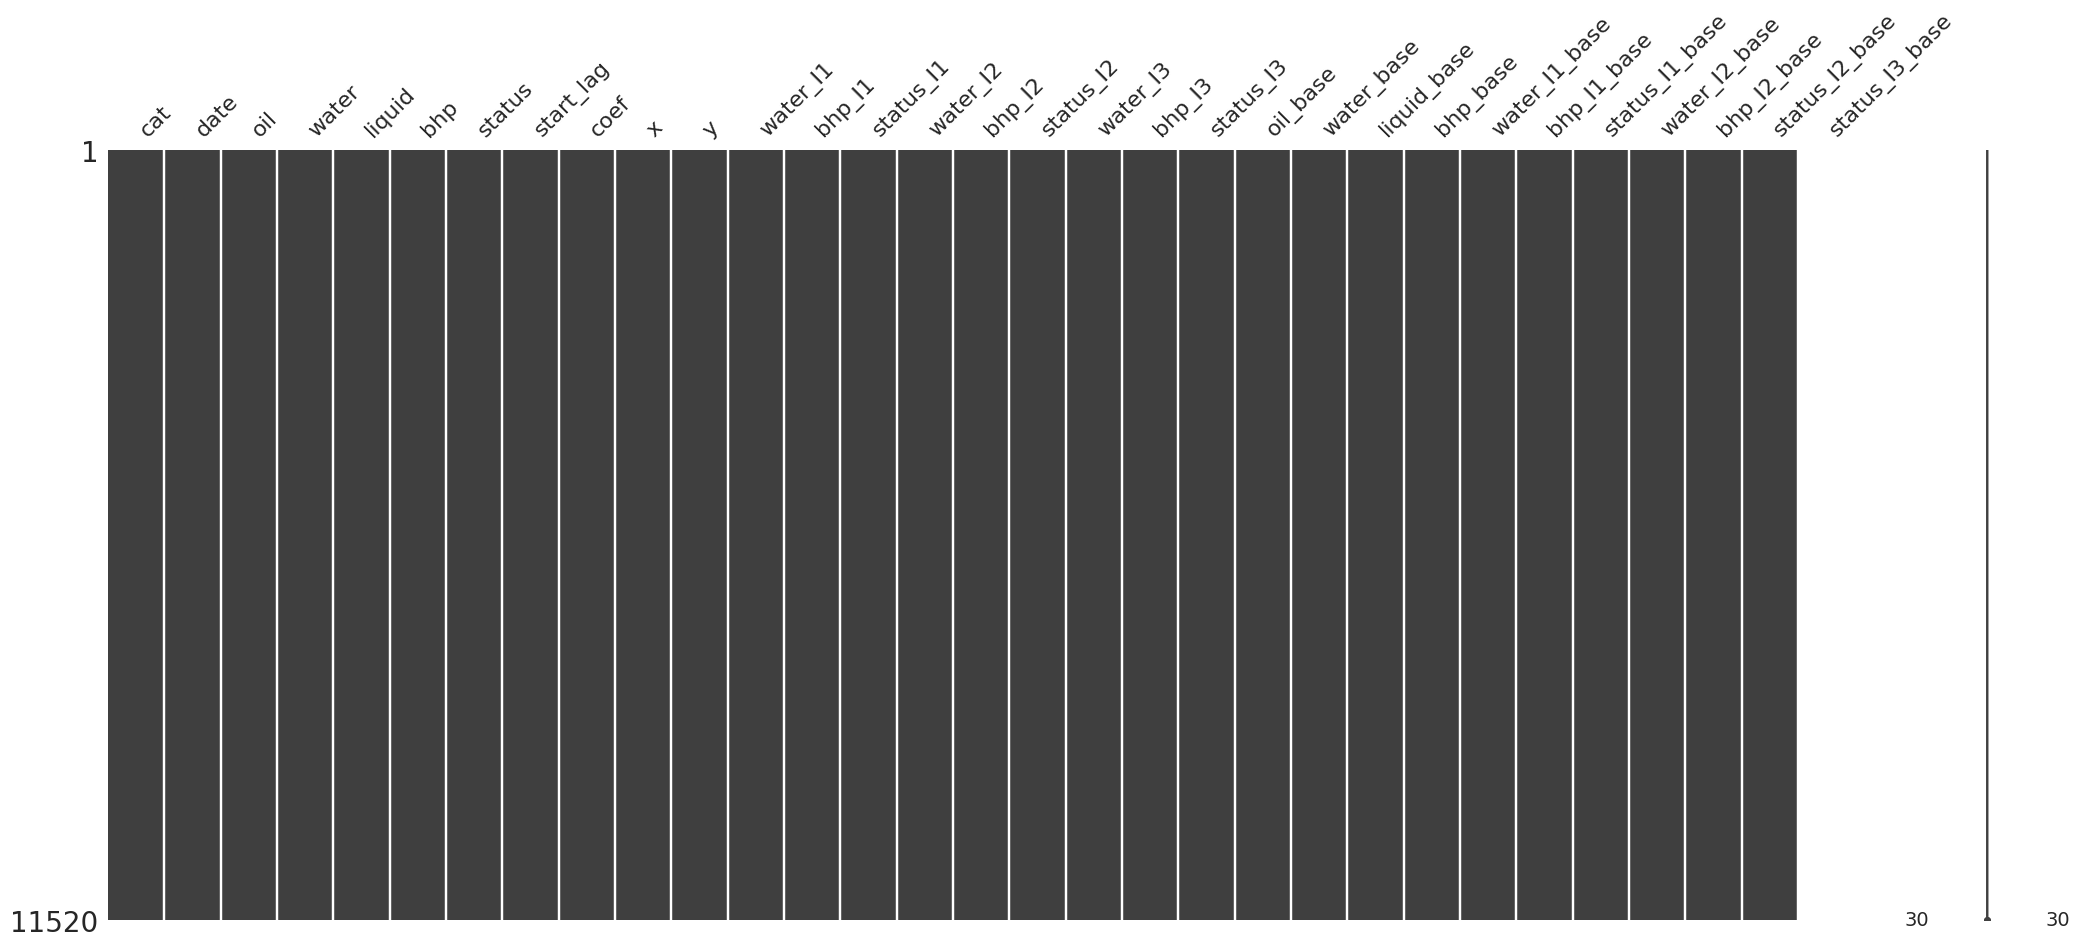

In [53]:
msno.matrix(non_baseline)
plt.show()

In [54]:
non_baseline = non_baseline.drop('status_I3_base', axis=1)

## 3.1 Initial Feature Selection <span class="anchor" id="initial-feature-selection"></span>

Drop columns with constant values


In [55]:
sel = VarianceThreshold(threshold=0)

sel.fit(non_baseline.drop(['cat'], axis=1))

cols2keep = non_baseline.drop(['cat'], axis=1).columns[sel.get_support()]

In [56]:
data_clean = non_baseline[['cat'] + list(cols2keep)]

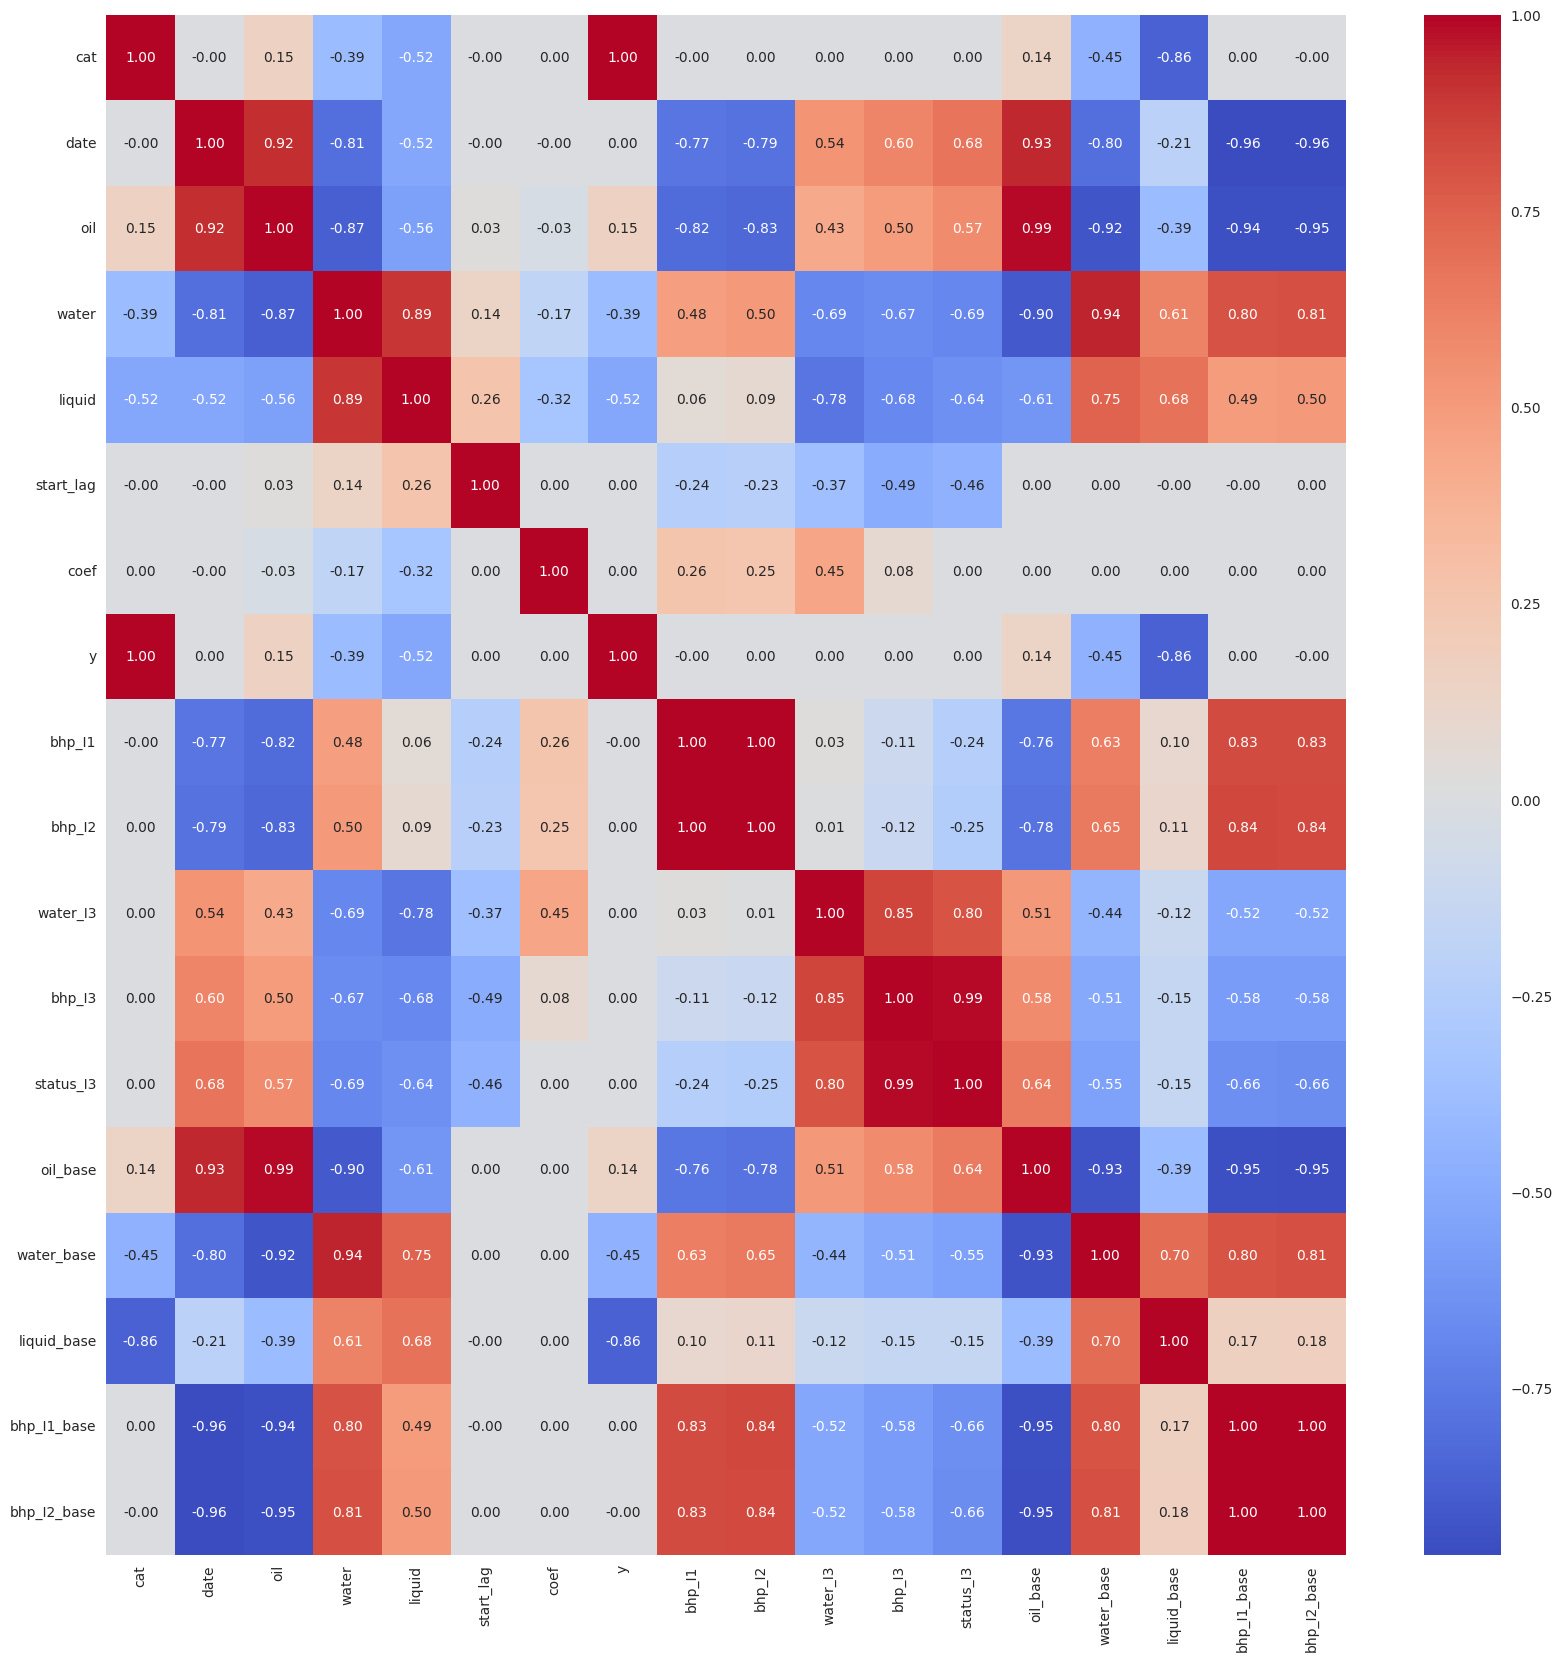

In [57]:
corr = data_clean.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')    
plt.show()

## 3.2 Feature Engineering <span class="anchor" id="feature-engineering"></span>

Create lags for each feature. I used lags from 1 to 27 days. 

In [58]:
data_lagged = data_clean.copy()
for i in range(1, 28):
    data_lagged = data_lagged.join(data_clean.groupby(['cat', 'start_lag', 'coef'])
                                             .shift(i)
                                             .add_suffix(f'_{i}d_ago')
                                             ).fillna(0)

- During my work, it appeared that the best perfomance is achieved when target is deviation from baseline. 
- Interestingly, the use of lagged deviations resulted in very poor performance.
- Same did the summary statistics of oil production.

In [60]:
data_lagged['delta_baseline'] = data_lagged['oil'] - data_lagged['oil_base']

In [59]:
# drop today's features
data_lagged = data_lagged.drop(['water_I3', 'bhp_I1', 'bhp_I2', 'bhp_I3'], axis=1)

## 3.3 Feature Selection from Random Forest <span class="anchor" id="feature-selection-from-random-forest"></span>

In [66]:
# train functions
def train_fn(data, model, horizon, cols):    
    train = data[data.date < horizon]
    test = data[(data.date >= horizon) & (data.date < horizon + 3)]

    # set -1 for features that are not available
    # i.e. on a day 5 when predicting for day 7
    # we don't have features for day 6
    
    for days_past, day in enumerate(test.date.unique()):
        for col in test.columns:
            for past in range(days_past + 1):
                if f'{past}d_ago' in col:
                    test.loc[test.date == day, col] = -1

    if cols is None:
        cols = data.columns.tolist()
        for col in ['oil', 'water', 'liquid', 'delta_baseline']:
            cols.remove(col)
    
    model.fit(X=train[cols], y=train.delta_baseline)
    afterI3 = test[test.status_I3 == 1]
    y_pred = model.predict(afterI3[cols])
    return mean_absolute_percentage_error(afterI3.oil, y_pred + afterI3.oil_base) * 100

def train_model(data, model, cols, stride=1):    
    mapes = [train_fn(data, model, i, cols) for i in range(2, 28, stride)]
    
    plt.bar(range(2, 28, stride), mapes)
    plt.title(f'MAPE for {model.__class__.__name__}, Mean = {np.mean(mapes):.2f}%')
    plt.xlabel('Horizon, day')
    plt.ylabel('MAPE, %')
    plt.show()
    return model

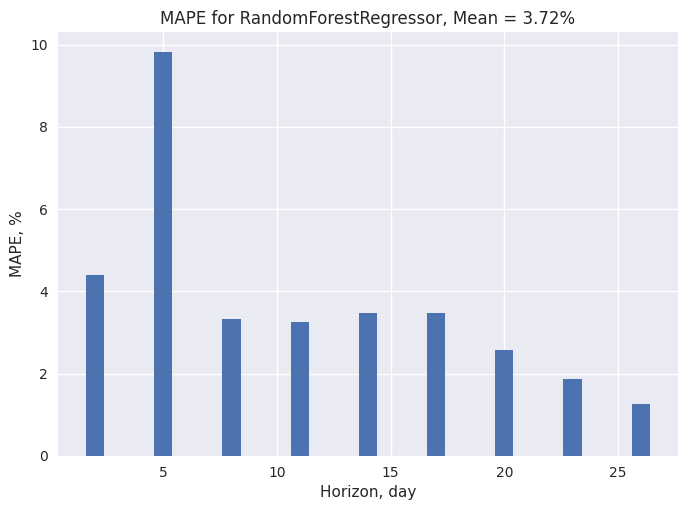

In [67]:
from sklearn.ensemble import RandomForestRegressor

rf = train_model(data_lagged, RandomForestRegressor(), stride=3,  cols=None)

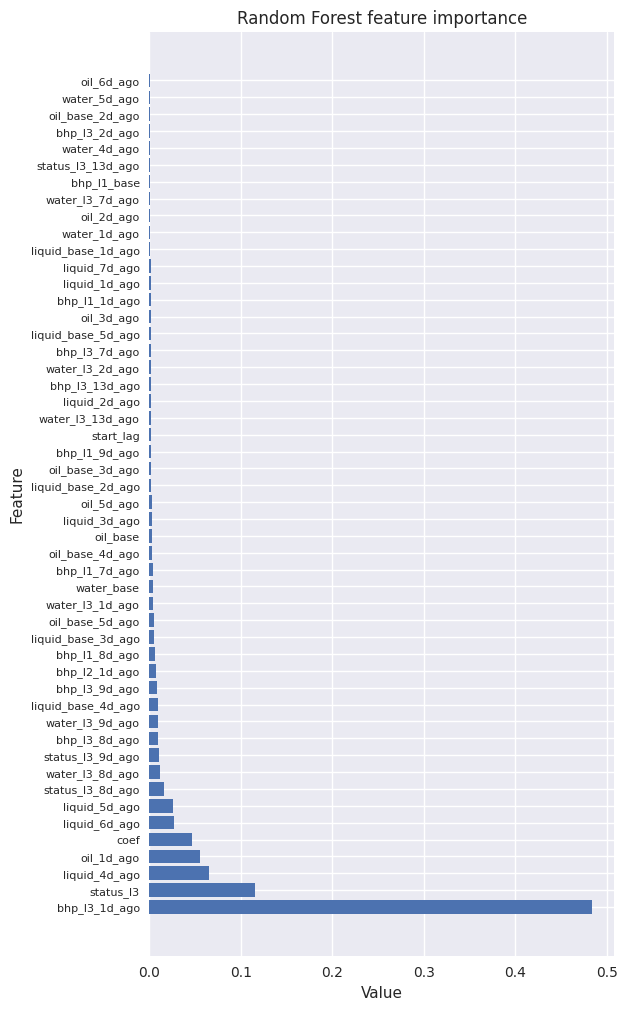

In [68]:
# plot feature importances
features = (pd.DataFrame({
                          'feature': rf.feature_names_in_,
                          'importance': rf.feature_importances_
                         })      
                          .sort_values('importance', ascending=False))

plt.figure(figsize=(6, 12))
plt.barh(features[:50].feature, features[:50].importance)
plt.title('Random Forest feature importance')
plt.xlabel('Value')
plt.ylabel('Feature')
plt.yticks(fontsize=8)
plt.show()

Kept 42 features


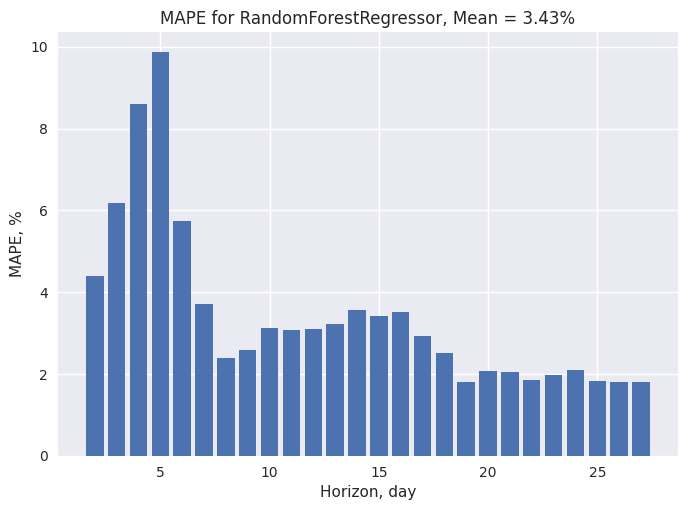

In [69]:
cols = features[features.importance > 0.001].feature.tolist()

print(f'Kept {len(cols)} features')

rf = train_model(data_lagged, RandomForestRegressor(), stride=1, cols=cols)

In [70]:
sorted(cols)

['bhp_I1_1d_ago',
 'bhp_I1_7d_ago',
 'bhp_I1_8d_ago',
 'bhp_I1_9d_ago',
 'bhp_I2_1d_ago',
 'bhp_I3_13d_ago',
 'bhp_I3_1d_ago',
 'bhp_I3_7d_ago',
 'bhp_I3_8d_ago',
 'bhp_I3_9d_ago',
 'coef',
 'liquid_1d_ago',
 'liquid_2d_ago',
 'liquid_3d_ago',
 'liquid_4d_ago',
 'liquid_5d_ago',
 'liquid_6d_ago',
 'liquid_7d_ago',
 'liquid_base_1d_ago',
 'liquid_base_2d_ago',
 'liquid_base_3d_ago',
 'liquid_base_4d_ago',
 'liquid_base_5d_ago',
 'oil_1d_ago',
 'oil_2d_ago',
 'oil_3d_ago',
 'oil_5d_ago',
 'oil_base',
 'oil_base_3d_ago',
 'oil_base_4d_ago',
 'oil_base_5d_ago',
 'start_lag',
 'status_I3',
 'status_I3_8d_ago',
 'status_I3_9d_ago',
 'water_1d_ago',
 'water_I3_13d_ago',
 'water_I3_1d_ago',
 'water_I3_2d_ago',
 'water_I3_8d_ago',
 'water_I3_9d_ago',
 'water_base']

### 3.3.1 Lags Interpretation <span class="anchor" id="lags-interpretation"></span> 

From this the clear delayed impact of injector wells can be seen.
1. BHP delay is somewhat around 7 to 13 days
2. Production well liquid flow rates have impact from now on up to 7 days back
3. Base oil flow rate has impact from now on up to 5 days back

# 4. Model Selection & Hyperparameter Tuning <span class="anchor" id="model-selection-hyperparameter-tuning"></span>

Model that performed best was Random Forest Regressor. 

I used my own TimeSeriesCV for hyperparameter tuning, because ready to use TimeSeriesSplit from sklearn does not take into account lagged features that we don't "have" yet. 

## 4.1 Hyperparameter Tuning <span class="anchor" id="hyperparameter-tuning"></span>

In [72]:
from itertools import product
from tqdm import tqdm

class GridCV:
    def __init__(self, 
                 model, 
                 params, 
                 test_size=3):
        
        self.model = model
        self.params = params
        self.test_size = test_size

    def _get_param_len(self):
        param_len = 1

        for param in self.params.values():
            param_len *= len(param)

        return param_len
    
    def _train_estimator(self, data, horizon, cols):    
        train = data[data.date < horizon]
        test = data[(data.date >= horizon) & (data.date < horizon + 3)]

        for days_past, day in enumerate(test.date.unique()):
            for col in test.columns:
                for past in range(days_past + 1):
                    if f'{past}d_ago' in col:
                        test.loc[test.date == day, col] = -1
        
        if cols is None:
            cols = data.columns.tolist()
            for col in ['oil', 'water', 'liquid', 'delta_baseline']:
                cols.remove(col)

        self.model.fit(X=train[cols], y=train.delta_baseline)
        y_pred = self.model.predict(test[cols])    
        return mean_absolute_percentage_error(test.oil, y_pred + test.oil_base) * 100
    
    def _cv(self, data, cols):
        mapes = [self._train_estimator(data, i, cols) for i in range(2, 27, 3)]
        return np.mean(mapes)
    
    def get_parameters(self):
        # returns all possible combinations of parameters
        return (dict(zip(self.params.keys(), values)) for values in product(*self.params.values()))

    def fit(self, data, cols):
        self.best_score = np.inf
        self.best_params = None
        
        with tqdm(self.get_parameters(), total=self._get_param_len()) as pbar:
            for params in pbar:
                self.model.set_params(**params)
                score = self._cv(data, cols)
                
                if score < self.best_score:
                    self.best_score = score
                    self.best_params = params

                pbar.set_postfix({'best_score': self.best_score, 'best_params': self.best_params})
                
        self.model.set_params(**self.best_params)
        self.model.fit(data[cols], data.delta_baseline)
        
        return self

In [ ]:
params = {'n_estimators': [100, 300],
          'max_depth': [5, 10],
          'min_samples_split': [2, 3, 5],
          'min_samples_leaf': [2, 3, 5],
          'max_features': [None, 0.5, 'sqrt']}

rf = RandomForestRegressor()
    
grid = GridCV(model=rf, 
              params=params)

grid.fit(data_lagged, cols=cols)

100%|██████████| 108/108 [31:26<00:00, 17.47s/it, best_score=1.64, best_params={'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}]


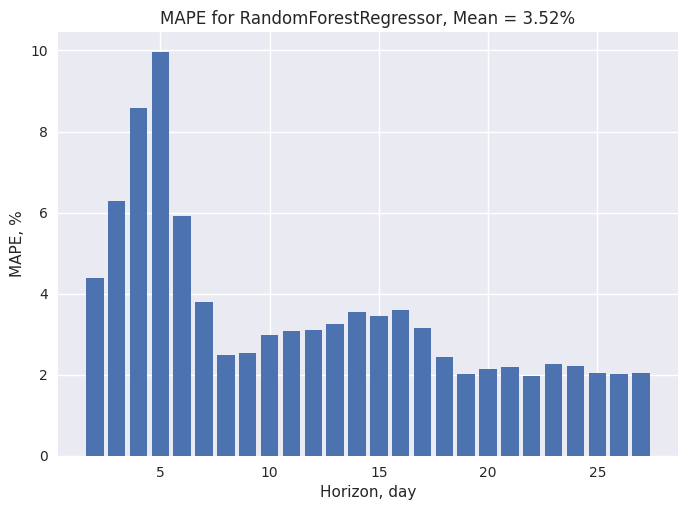

In [77]:
rf = train_model(data_lagged, RandomForestRegressor(**grid.best_params), stride=1, cols=cols)

## 4.2 Model Sanity Check <span class="anchor" id="model-sanity-check"></span>

In [78]:
# fucntion returns lower and upper bounds of prediction intervals
def pred_ints(model: RandomForestRegressor, X: pd.DataFrame, percentile=95):
    err_down = []
    err_up = []
    
    for x in range(len(X)):
        preds = [pred.predict(np.array(X.iloc[x], ndmin=2)) for pred in model.estimators_]
        err_down.append(np.percentile(preds, (100 - percentile) / 2. ))
        err_up.append(np.percentile(preds, 100 - (100 - percentile) / 2.))

    return np.array(err_down), np.array(err_up)

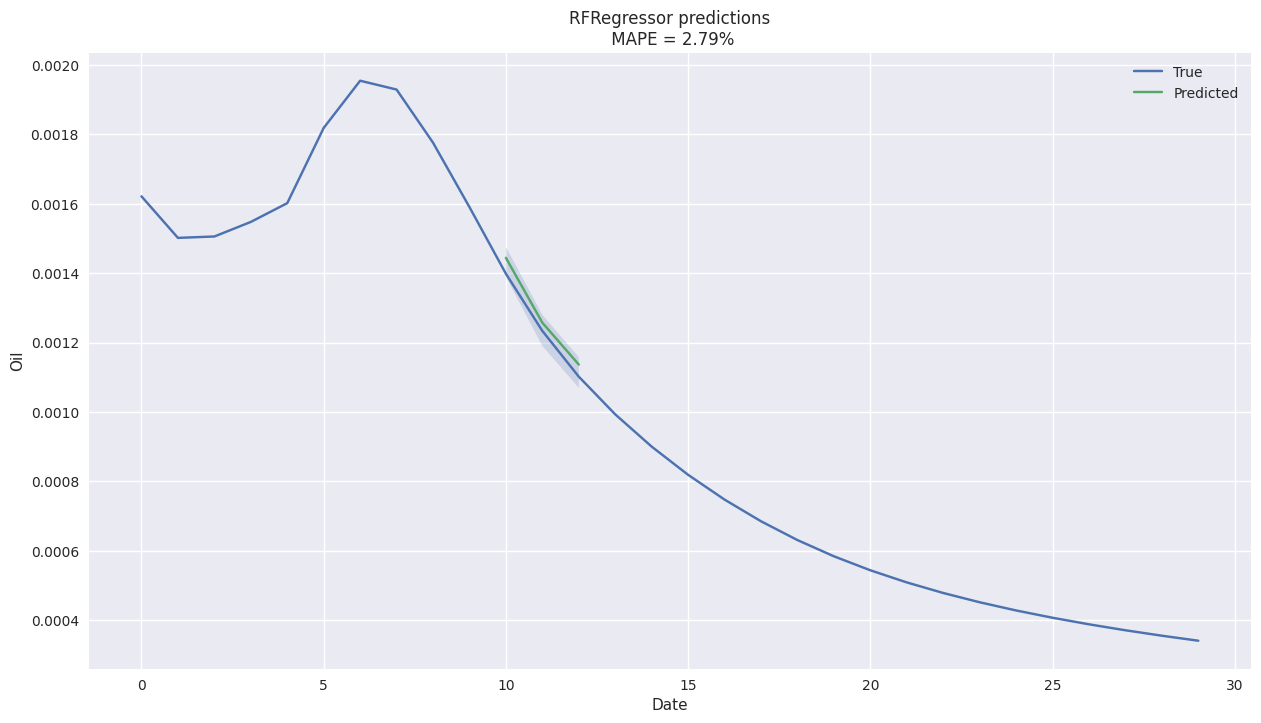

In [118]:
# you can play around with this cell to see model's performance
DATE = 10
HORIZON = 3
COEF = 0.17
LAG = 1
CAT = 1

train = data_lagged[(data_lagged.date < DATE) &
                    (data_lagged.coef == COEF) &
                    (data_lagged.cat == CAT)]

test = data_lagged[(data_lagged.date >= DATE) & (data_lagged.date < DATE + HORIZON) &
                    (data_lagged.coef == COEF) &
                    (data_lagged.start_lag == LAG) &
                    (data_lagged.cat == CAT)]

for days_past, day in enumerate(test.date.unique()):
    for col in test.columns:
        for past in range(days_past + 1):
            if f'{past}d_ago' in col:
                test.loc[test.date == day, col] = -1

X_sample = test[cols]
y_sample = test.delta_baseline

X_train = train[cols]
y_train = train.delta_baseline
rf.fit(X_train, y_train)

sample_pred = rf.predict(X_sample)
sample_lower, sample_upper = pred_ints(rf, X_sample, percentile=95)

sample_true = data_lagged[(data_lagged.start_lag == LAG) &
                          (data_lagged.coef == COEF) &
                          (data_lagged.cat == CAT)]

plt.figure(figsize=(15, 8))
plt.plot(sample_true.date, - sample_true.oil, label='True')
plt.plot(test.date, - sample_pred - test.oil_base, label='Predicted')
plt.fill_between(test.date, - sample_lower - test.oil_base, - sample_upper - test.oil_base, alpha=0.2)

plt.title(f'RFRegressor predictions\
\n MAPE = {mean_absolute_percentage_error(test.oil, sample_pred + test.oil_base) * 100:.2f}%')
plt.xlabel('Date')
plt.ylabel('Oil')
plt.legend()
plt.show()

# 5. Model Evaluation & Error Analysis <span class="anchor" id="model-evaluation-error-analysis"></span>

In [130]:
# training funcs that return MAPE for each day
def train_fn(data, model, horizon, cols):    
    train = data[data.date < horizon]
    test = data[(data.date >= horizon) & (data.date < horizon + 3)]

    for days_past, day in enumerate(test.date.unique()):
        for col in test.columns:
            for past in range(days_past + 1):
                if f'{past}d_ago' in col:
                    test.loc[test.date == day, col] = -1

    if cols is None:
        cols = data.columns.tolist()
        for col in ['oil', 'water', 'liquid', 'delta_baseline']:
            cols.remove(col)
    
    model.fit(X=train[cols], y=train.delta_baseline)
    
    afterI3 = test[test.status_I3 == 1]
    y_pred = model.predict(afterI3[cols])
    return np.abs((afterI3.delta_baseline - y_pred) / afterI3.oil * 100)

def train_model(data, model, cols, stride=1):    
    mapes = [train_fn(data, model, i, cols) for i in range(1, 27, stride)]
    return np.hstack(mapes)

def plot_mape(mapes):
    plt.figure(figsize=(10, 5))
    plt.hist(mapes, bins=100)
    q95 = np.quantile(mapes, 0.95)
    plt.title(f'Error disstribution\n{q95 = :.2f}%')
    plt.axvline(q95, color='red', linestyle='--', label='95% quantile')
    plt.xlabel('MAPE')
    plt.ylabel('Count')
    plt.legend()
    plt.show()  

## 5.1 Error Distribution <span class="anchor" id="error-distribution"></span>

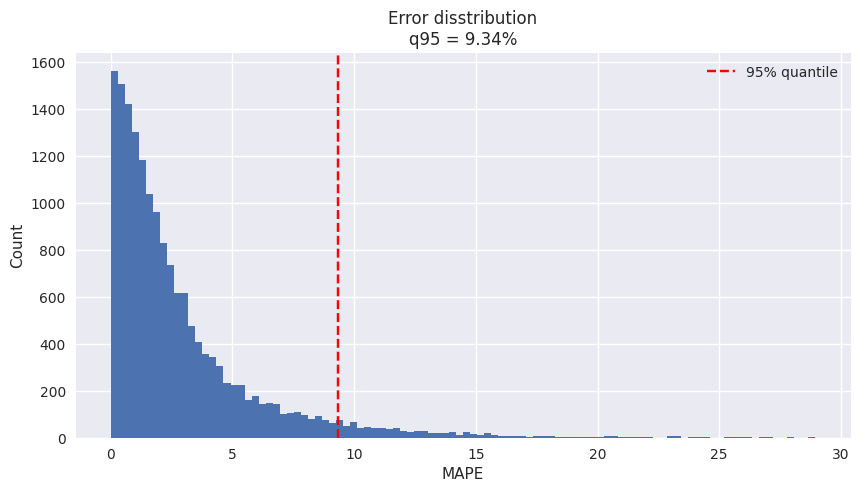

In [131]:
rf_params = {'n_estimators': 300, 
             'max_depth': 10, 
             'min_samples_split': 5, 
             'min_samples_leaf': 2, 
             'max_features': None,
             'n_jobs': 2,
             'random_state': 42}

rf = RandomForestRegressor(**rf_params)

mapes = train_model(data_lagged, rf, cols, stride=1)
plot_mape(mapes)

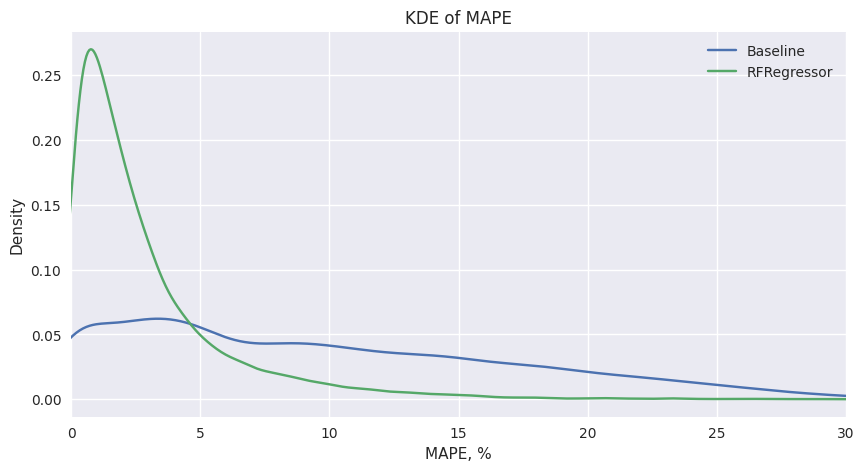

In [97]:
mapes_df = pd.DataFrame({'mape': mapes})
baseline_mapes = pd.read_csv('../data/1905-zeinovich-baseline.csv')

#plot kde of mapes
plt.figure(figsize=(10, 5))
plt.title('KDE of MAPE')
plt.xlabel('MAPE, %')
plt.ylabel('Frequency')
plt.xlim(0, 30)
baseline_mapes.mape.plot.kde()
mapes_df.mape.plot.kde()
plt.legend(['Baseline', 'RFRegressor'])
plt.show()

## 5.2 Quantile Comparison with Baseline <span class="anchor" id="error-quantile-comparison"></span>

To compare the performance of the model with the baseline, I used quantile comparison. I compared the 0.5, 0.75, 0.9, 0.95 quantiles of the model with the same quantiles of the baseline.

Error bars represent 3-sigma confidence interval.

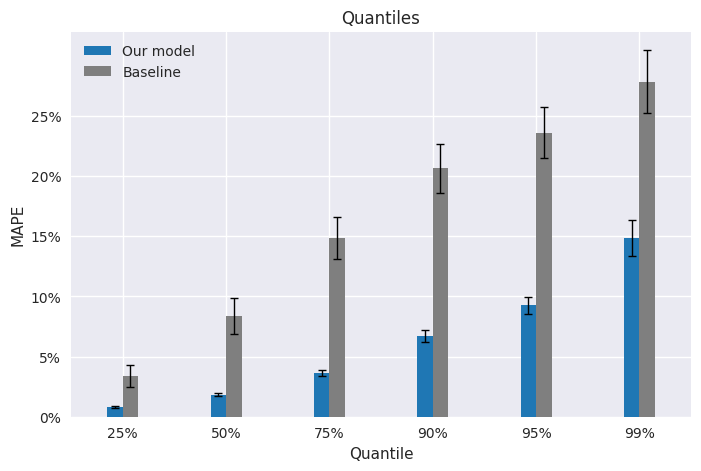

In [96]:
# bootstrap confidence interval for quantiles
def bootstrap(data, n_samples=4000, n_iters=500, quantile=0.95):
    sample = np.random.choice(data, size=(n_samples, n_iters), replace=True)
    return np.quantile(sample, quantile, axis=1)

plt.figure(figsize=(8, 5))

for i, q in enumerate([0.25, 0.5, 0.75, 0.9, 0.95, 0.99], start=1):
    plt.bar(x=i/5-0.015, height=bootstrap(mapes, quantile=q).mean(),
            yerr=bootstrap(mapes, quantile=q).std(), width=0.03, color='tab:blue', 
            capsize=3, error_kw={'capthick': 1, 'elinewidth': 1})
    
    plt.bar(x=i/5+0.015, height=bootstrap(baseline_mapes.mape, quantile=q).mean(),
            yerr=3 * bootstrap(baseline_mapes.mape, quantile=q).std(), width=0.03, color='tab:grey', 
            capsize=3, error_kw={'capthick': 1, 'elinewidth': 1})
    

plt.title('Quantiles')
plt.xlabel('Quantile')
plt.ylabel('MAPE')

plt.xticks([0.2, 0.4, 0.6, 0.8, 1, 1.2], ['25%', '50%', '75%', '90%', '95%', '99%'])
plt.yticks([0, 5, 10, 15, 20, 25], ['0%', '5%', '10%', '15%', '20%', '25%'])
plt.xlim(0.1, 1.3)
plt.legend(['Our model', 'Baseline'])
plt.show()

## 5.3 Statistical Significance <span class="anchor" id="statistical-significance"></span>

Two samples compared have shown statistically significant difference using Mann-Whitney U test for means and Kolmogorov-Smirnov test for distributions. 

Model's error distribution is shifted to the left and has lower mean.

In [103]:
from scipy.stats import mannwhitneyu, ks_2samp

stat, p = mannwhitneyu(mapes, baseline_mapes.mape, alternative='less')
print(f'U-test p-value = {p:.4f}')

stat, p = ks_2samp(mapes, baseline_mapes.mape, alternative='less')
print(f'KS-test p-value = {p:.4f}')


U-test p-value = 0.0000
KS-test p-value = 0.0000


## 5.4 Error Analysis by coef <span class="anchor" id="error-analysis-by-coef"></span>

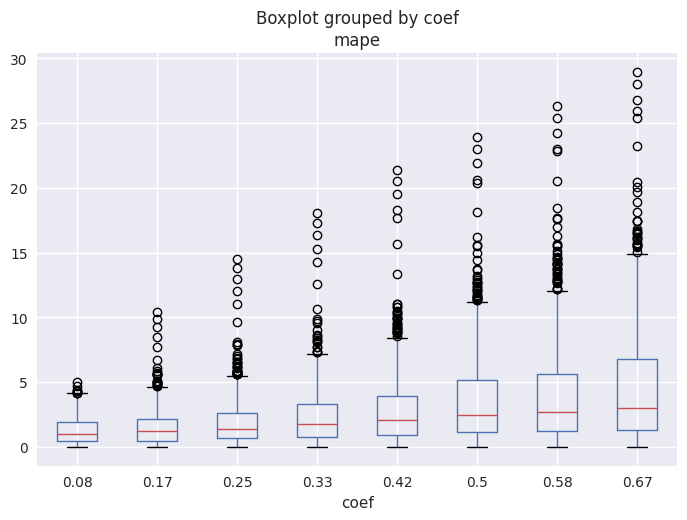

In [142]:
# plot errors for each coef
def train_fn(data, model, horizon, cols):    
    train = data[data.date < horizon]
    test = data[(data.date >= horizon) & (data.date < horizon + 3)]

    for days_past, day in enumerate(test.date.unique()):
        for col in test.columns:
            for past in range(days_past + 1):
                if f'{past}d_ago' in col:
                    test.loc[test.date == day, col] = -1

    if cols is None:
        cols = data.columns.tolist()
        for col in ['oil', 'water', 'liquid', 'delta_baseline']:
            cols.remove(col)

    model.fit(X=train[cols], y=train.delta_baseline)

    afterI3 = test[test.status_I3 == 1]
    y_pred = model.predict(afterI3[cols])
    mape = np.abs((afterI3.delta_baseline - y_pred) / afterI3.oil * 100)
    mape = pd.DataFrame({'coef': afterI3.coef, 'mape': mape})
    return mape

def train_model(data, model, cols, stride=1):    
    mapes = [train_fn(data, model, i, cols) for i in range(1, 28, stride)]
    return np.array(mapes, dtype='object')

def plot_coef_errors(data, model, cols, stride=1):
    mapes = train_model(data, model, cols, stride)
    mapes_df = pd.concat(mapes)
    mapes_df.boxplot(column='mape', by='coef')
    plt.show()
    return mapes_df

rf1 = RandomForestRegressor(**rf_params)
mapes_df = plot_coef_errors(data_lagged, rf1, cols, stride=3)

The higher the coef, the higher the error. This may be due to much higher variance of the data for higher coefs.

# 6. Suggestions for Improvement <span class="anchor" id="suggestions-for-improvement"></span>

1. With higher coefficients model tends to overestimate the target. Features indicating total oil production may be used, however, they did not improve the performance of the model.
2. Model is not much physical, so it may be improved by adding some physical constraints. For example, information about viscosity of the oil in volume nearby P1 & P2 may be helpful, as well as geospatial information of reservoir and wells.
3. Simple RNN may have better performance, however will be much harder to fine-tune.
4. Throughout this work, the error on days from 4 to 6 stood out decently. No matter what model was trained and how poor it performed, errors on this dates deviated a lot from general trend. However, it was still less than baseline. Further inspection and interpretation might be helpful.

# 7. Summary <span class="anchor" id="summary"></span>

As a result of work, model for P1 & P2 injection wells was created. In process of feature engineering and selection, lags with biggest impact were identified, that be lags of BHP and flow rates for injection well and lags of flow rates for production wells up to 13 days back (8 day lag repeatedly shown significant impact on performance regardless of model trained). Features were first selected using VarianceThreshold and then using Random Forest Regressor.

For baseline, Dummy Regressor was used. It always returns baseline value for target. Its error distribution was then used to compare with model's error distribution.

Model that performed best was Random Forest Regressor (RFR). It was fine-tuned using TimeSeriesCV with slight changes to account for specificity of the data. The RFR was trained such that it gets the data only from days prior to prediction date. The target was changed to be deviation of oil production from baseline.

Model significantly outperformed baseline, which was proven by MAPE quantile comparison and statistical tests. Nevertheless, model's performance is not perfect and sometimes its predictions are highly confusing. It may be improved int the future by adding more features and physical constraints.